<a href="https://colab.research.google.com/github/SophieShin/NLP_22_Fall/blob/main/%5BSSH%5Dlab06_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6
## Part 1: Character Generation using RNN
We can use a language model to not only predict the next word in a sequence but the next word after that, and the next...if we continued this repeated sampling, we can generate text! We are going to use a simple character-based RNN language model to learn to generate characters from a simple training corpus of a few sentences.

In [ ]:
import torch
from torch import nn

import numpy as np

First, we'll define the sentences that we want our model to output when fed with the first word or the first few characters.

Then we'll create a dictionary (vocab) out of all the characters that we have in the sentences and map them to an integer. This will allow us to convert our input characters to their respective integers (`char2int` or `vocab`) and vice versa (`int2char`). We will use just basic Python without torchtext utlities.

In [ ]:
corpus = ['hey how are you','good i am fine','have a nice day', 'see you later']

# Tokenise
# Join all the sentences together and extract the unique characters from the combined sentences
chars = set(''.join(corpus))  # ''.join('**')는 '***'안에 있는 모든 단어를 이어붙인다. # set은 안에 있는 문자를 character 단위로 쪼개서 set형태로 만든다.

# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars)) # chars에 있는 문자에 idx를 부여하고 이를 dictionary화 한다. # key : ind, value: character
print( f'int2char: {int2char}')

# Creating another dictionary that maps characters to integers (vocab) # key: character, value : idx
char2int = {char: ind for ind, char in int2char.items()} # int2char.items()로 하면 key(idx)와 value가 튜플 형태로 나옴
vocab = char2int
print(f'char2int: {char2int}')

int2char: {0: 'v', 1: 'o', 2: 'r', 3: 'w', 4: 'm', 5: 'i', 6: ' ', 7: 'a', 8: 'd', 9: 'u', 10: 'n', 11: 'g', 12: 'y', 13: 's', 14: 'e', 15: 'h', 16: 'f', 17: 't', 18: 'c', 19: 'l'}
char2int: {'v': 0, 'o': 1, 'r': 2, 'w': 3, 'm': 4, 'i': 5, ' ': 6, 'a': 7, 'd': 8, 'u': 9, 'n': 10, 'g': 11, 'y': 12, 's': 13, 'e': 14, 'h': 15, 'f': 16, 't': 17, 'c': 18, 'l': 19}


In [ ]:
int2char[7]

'a'

In [ ]:
int2char.items()

dict_items([(0, 'v'), (1, 'o'), (2, 'r'), (3, 'w'), (4, 'm'), (5, 'i'), (6, ' '), (7, 'a'), (8, 'd'), (9, 'u'), (10, 'n'), (11, 'g'), (12, 'y'), (13, 's'), (14, 'e'), (15, 'h'), (16, 'f'), (17, 't'), (18, 'c'), (19, 'l')])

### Print the vocab

In [ ]:
print(vocab)
print(len(vocab))

{'v': 0, 'o': 1, 'r': 2, 'w': 3, 'm': 4, 'i': 5, ' ': 6, 'a': 7, 'd': 8, 'u': 9, 'n': 10, 'g': 11, 'y': 12, 's': 13, 'e': 14, 'h': 15, 'f': 16, 't': 17, 'c': 18, 'l': 19}
20


### Padding
Next, we'll be padding our input sentences to ensure that all the sentences are of the sample length. While RNNs are typically able to take in variably sized inputs, we will usually want to feed training data in batches to speed up the training process. In order to use batches to train on our data, we'll need to ensure that each sequence within the input data are of equal size.

Therefore, in most cases, padding can be done by filling up sequences that are too short with 0 values and trimming sequences that are too long. In our case, we'll be finding the length of the longest sequence and padding the rest of the sentences with blank spaces to match that length.

In [ ]:
max(corpus, key=len) #max(str, key=len) 문자열의 길이가 가장 큰 것을 반환한다. 단, 최댓값의 길이가 두 개 이상 있을 경우 index가 가장 작은 것을 출력한다.

'hey how are you'

In [ ]:
max(corpus) # idx가 제일 큰 값을 반환

'see you later'

In [ ]:
len(max(corpus, key = len))

15

In [ ]:
maxlen = len(max(corpus, key=len))
print(f"The longest string has {maxlen} characters")

The longest string has 15 characters


In [ ]:
# A simple loop that loops through the list of sentences and adds a ' ' whitespace until the length of the sentence matches
# the length of the longest sentence
for i in range(len(corpus)):
    while len(corpus[i])<maxlen:
        corpus[i] += ' '
        print(corpus[i])

### Break up data into Inputs (`x`) and Targets (`y`)
As we're going to predict the next character in the sequence at each time step, we'll have to divide each sentence into

- Input data
  - The last input character should be excluded as it does not need to be fed into the model

- Target/Ground Truth Label
  - One time-step ahead of the Input data as this will be the "correct answer" for the model at each time step corresponding to the input data

In [ ]:
for i in range(len(corpus)):
  print(len(corpus[i]))

15
15
15
15


In [ ]:
# Creating lists that will hold our input and target sequences
input_sequence = []
target_seq = []

for i in range(len(corpus)):
    # Remove last character for input sequence
    input_sequence.append(corpus[i][:-1])
    
    # Remove first character for target sequence
    target_seq.append(corpus[i][1:])
    print(f"Input Sequence\t: {input_sequence[i]}\nTarget Sequence\t: {target_seq[i]}")

Input Sequence	: hey how are yo
Target Sequence	: ey how are you
Input Sequence	: good i am fine
Target Sequence	: ood i am fine 
Input Sequence	: have a nice da
Target Sequence	: ave a nice day
Input Sequence	: see you later 
Target Sequence	: ee you later  


### Lookup vocab for inputs and targets
Now we can convert our input and target sequences to sequences of integers instead of characters by mapping them using the dictionaries we created above. This will allow us to one-hot-encode our input sequence subsequently.

In [ ]:
for i in range(len(corpus)):
    input_sequence[i] = [vocab[character] for character in input_sequence[i]]
    target_seq[i] = [vocab[character] for character in target_seq[i]]

In [ ]:
print(input_sequence)
print(target_seq)

[[15, 14, 12, 6, 15, 1, 3, 6, 7, 2, 14, 6, 12, 1], [11, 1, 1, 8, 6, 5, 6, 7, 4, 6, 16, 5, 10, 14], [15, 7, 0, 14, 6, 7, 6, 10, 5, 18, 14, 6, 8, 7], [13, 14, 14, 6, 12, 1, 9, 6, 19, 7, 17, 14, 2, 6]]
[[14, 12, 6, 15, 1, 3, 6, 7, 2, 14, 6, 12, 1, 9], [1, 1, 8, 6, 5, 6, 7, 4, 6, 16, 5, 10, 14, 6], [7, 0, 14, 6, 7, 6, 10, 5, 18, 14, 6, 8, 7, 12], [14, 14, 6, 12, 1, 9, 6, 19, 7, 17, 14, 2, 6, 6]]



### One-hot Encoding
Before encoding our input sequence into one-hot vectors, we'll define 3 key variables:

- `vocab_size`: The number of unique characters that we have in our text. This will determine the one-hot vector size as each character will have an assigned index in that vector
- `seq_len`: The length of the sequences that we're feeding into the model. As we standardised the length of all our sentences to be equal to the longest sentences, this value will be the `max length - 1` as we removed the last character input as well
- `batch_size`: Since our training corpus is small, we will send each sentence in the corpus as a batch to the model

In [ ]:
vocab_size = len(vocab)
seq_len = maxlen - 1
batch_size = len(corpus)

def one_hot_encode(sequence, vocab_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, vocab_size), dtype=np.float32)    #  4*14*20 tensor
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1  #input_sequence의 [i, u] 자리에 있는 숫자를 가지고 오고 vocab_size의 그 숫자 자리에만 1을 할당한다.

    return features

In [ ]:
input_sequence

[[15, 14, 12, 6, 15, 1, 3, 6, 7, 2, 14, 6, 12, 1],
 [11, 1, 1, 8, 6, 5, 6, 7, 4, 6, 16, 5, 10, 14],
 [15, 7, 0, 14, 6, 7, 6, 10, 5, 18, 14, 6, 8, 7],
 [13, 14, 14, 6, 12, 1, 9, 6, 19, 7, 17, 14, 2, 6]]

In [ ]:
print(features[3])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
input_seq = one_hot_encode(input_sequence, vocab_size, seq_len, batch_size)
print(f"Input shape: {input_seq.shape}") 

Input shape: (4, 14, 20)


In [ ]:
# Q1. What do the numbers in the input tensor shape represent?
# A1. It represent batch_size, the maximum length, and the size of vocabulary. The size of vocaburary tensor is 1*20 and it's one-hot encoded tensor.

### Convert to Tensors

In [ ]:
input_seq = torch.from_numpy(input_seq) # array to tensor
target_seq = torch.Tensor(target_seq) # list to tenspr

### RNN Model
That's all the preprocessing done. We can now define the NN class.
This class can take in some parameters when instantiated:
`input_size, output_size, hidden_dim, n_layers`

For this model, we’ll only be using 1 layer of RNN followed by a fully connected layer. The fully connected layer will be in-charge of converting the RNN output to our desired output shape.

The order the forward function is sequentially executed, therefore we’ll have to pass the inputs and the zero-initialized hidden state through the RNN layer first, before passing the RNN outputs to the fully-connected layer. Note that we are using the layers that we defined in the constructor.

The last method that we have to define is the method that we called earlier to initialize the hidden state - init_hidden(). This basically creates a tensor of zeros in the shape of our hidden states.


#### * parameters of nn.RNN
(https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- input_size = the number of expected features in the input X
- hidden_size = the number of features in the hidden state h
- num_layers = the number of recurrent layers(if 2, it means stacking two RNN together)
- batch first = if True, the input and output tensors are the form of (batch, seq, feature). This does not apply to hidden or cell states. default: False.

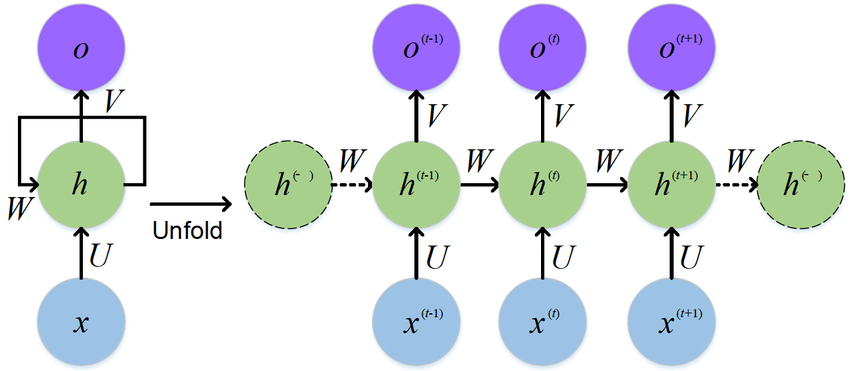

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True) # input format is [batch_size, input_size, hidden_size]  
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.shape[0]

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim) # pytorch requires the targets in the loss to be continguous in memory, 
                                                         # but the inputs of neural net don't need to satisfy this requirement.
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

### Instantiate model, loss and optimiser

In [ ]:
input_seq.shape[0]

4

In [ ]:
model = CharRNN(input_size=vocab_size, output_size=vocab_size, hidden_dim=20, n_layers=1)

# Define hyperparameters
n_epochs = 200
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Train!

In [ ]:
target_seq

tensor([[14., 12.,  6., 15.,  1.,  3.,  6.,  7.,  2., 14.,  6., 12.,  1.,  9.],
        [ 1.,  1.,  8.,  6.,  5.,  6.,  7.,  4.,  6., 16.,  5., 10., 14.,  6.],
        [ 7.,  0., 14.,  6.,  7.,  6., 10.,  5., 18., 14.,  6.,  8.,  7., 12.],
        [14., 14.,  6., 12.,  1.,  9.,  6., 19.,  7., 17., 14.,  2.,  6.,  6.]])

In [ ]:
target_seq.view(-1).long()

tensor([14, 12,  6, 15,  1,  3,  6,  7,  2, 14,  6, 12,  1,  9,  1,  1,  8,  6,
         5,  6,  7,  4,  6, 16,  5, 10, 14,  6,  7,  0, 14,  6,  7,  6, 10,  5,
        18, 14,  6,  8,  7, 12, 14, 14,  6, 12,  1,  9,  6, 19,  7, 17, 14,  2,
         6,  6])

In [ ]:
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch...(1)
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients........(2)
    optimizer.step() # Updates the weights accordingly.....................(3)
    
    if epoch%10 == 0:
        print(f"Epoch: {epoch}/{n_epochs}.............", end=" ")
        print(f"Loss: {loss.item():.4f}")

Epoch: 10/200............. Loss: 2.4501
Epoch: 20/200............. Loss: 2.1607
Epoch: 30/200............. Loss: 1.6592
Epoch: 40/200............. Loss: 1.0996
Epoch: 50/200............. Loss: 0.6711
Epoch: 60/200............. Loss: 0.3798
Epoch: 70/200............. Loss: 0.2152
Epoch: 80/200............. Loss: 0.1327
Epoch: 90/200............. Loss: 0.0929
Epoch: 100/200............. Loss: 0.0728
Epoch: 110/200............. Loss: 0.0614
Epoch: 120/200............. Loss: 0.0543
Epoch: 130/200............. Loss: 0.0494
Epoch: 140/200............. Loss: 0.0458
Epoch: 150/200............. Loss: 0.0431
Epoch: 160/200............. Loss: 0.0409
Epoch: 170/200............. Loss: 0.0391
Epoch: 180/200............. Loss: 0.0377
Epoch: 190/200............. Loss: 0.0364
Epoch: 200/200............. Loss: 0.0354


### Utility to Convert Prediction Back to Text

In [ ]:
def predict(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[vocab[c] for c in character]])
    character = one_hot_encode(character, vocab_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    
    out, hidden = model(character)

    prob = nn.functional.softmax(out[-1], dim=0).data   # 왜 .data가 붙는지.. 없어도 실행이 되기는 함 . out[-1] 도 어떤 뜻인지
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden

In [ ]:
model

CharRNN(
  (rnn): RNN(20, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=20, bias=True)
)

## Utility to Generate Text
- Pass in the model, the length of characters to generate and a start sequence
- Final sequence length will include the start sequence 

In [ ]:
def generate(model, out_len=15, start='hey'):
    model.eval() # eval mode # evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for i in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

### Test with a sample start string

In [ ]:
generate(model, 18, 'good')

'good i am fine day'

Try with your own sample start string and output length (make sure the character(s) you enter are in the vocab
- Try with short output lengths (<=15)
- Try with start words that are not proper words in the vocab, e.g. "sa", "yu", "fai"
- Try with longer lengths, e.g. 30, 60

In [ ]:
generate(model, 30, 'are')

'are you later  are dar fine da'

In [ ]:
# Q2. What are your observations? Try tweaking some hyperparameters and see if better texts are generated.
# State what you changed and what you think is "better" text.
# A2. I've changed the hidden dimension to 20 and increase the number of epoch to 200.
# Better text can be regarded sentences or expressions that people natually understand.
# In this case, the training data is not enough to train the model effectively.
# If we generate with the word that are included in the training data, it generates decent one,however,
# with unseen word, the result is disappointing. 

References:
- https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/

# Part 2 – RNNs for Text Classification using AG_NEWS
Last time, we predicted the class of a new piece based on its text. We used EmbeddingBag layer that computes sums or means of bags of embeddings in a news piece to obtain a representation of the text. We then built a model to predict the news class based on its representation.

One of the drawbacks of the previous approach is that the order of words is lost. The news "the Dodgers beat the Giants" and "the Giants beat the Dodgers" would have the exact same embedding, even though the sentences have different meanings.

### Learning Outcomes:
- We wil use a recurrent neural network. We will treat each news as a sequence of words
- We will use pre-trained GloVe embeddings as inputs to the recurrent network. 
- We will use tqdm add a progress bar when training
- We will use `sklearn.metrics` to 
  - Report on model accuracy and other classification metrics
  - Retrieve the confusion matrix that summarise the number of correct and incorrect predictions
- We will use `scikitplot` to visualise the confusion matrix

In [ ]:
# Install torchdata and restart runtime
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 140 kB 53.0 MB/s 
     |████████████████████████████████| 127 kB 54.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import torch
import torchtext

### Pre-trained GloVe embeddings
- We are going to use pre-trained embeddings to represent the words
- They are available in torchtext
- We will use 6B dim-50 (Takes around 3m to download)

In [ ]:
from torchtext.vocab import GloVe

glovemb = GloVe(name='6B', dim=50, max_vectors=10000) # use 10k most common words
# pre-trained vectors loaded. Most pre-trained vector sets are sorted in the descending order of word frequency. 
# Thus, in situations where the entire set doesn’t fit in memory, or is not needed for another reason, 
# passing max_vectors can limit the size of the loaded set.

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 9999/10000 [00:00<00:00, 33326.77it/s]


Get some embeddings

In [ ]:
glovemb.get_vecs_by_tokens(["you"]) #Look up embedding vectors of tokens.

tensor([[-1.0919e-03,  3.3324e-01,  3.5743e-01, -5.4041e-01,  8.2032e-01,
         -4.9391e-01, -3.2588e-01,  1.9972e-03, -2.3829e-01,  3.5554e-01,
         -6.0655e-01,  9.8932e-01, -2.1786e-01,  1.1236e-01,  1.1494e+00,
          7.3284e-01,  5.1182e-01,  2.9287e-01,  2.8388e-01, -1.3590e+00,
         -3.7951e-01,  5.0943e-01,  7.0710e-01,  6.2941e-01,  1.0534e+00,
         -2.1756e+00, -1.3204e+00,  4.0001e-01,  1.5741e+00, -1.6600e+00,
          3.7721e+00,  8.6949e-01, -8.0439e-01,  1.8390e-01, -3.4332e-01,
          1.0714e-02,  2.3969e-01,  6.6748e-02,  7.0117e-01, -7.3702e-01,
          2.0877e-01,  1.1564e-01, -1.5190e-01,  8.5908e-01,  2.2620e-01,
          1.6519e-01,  3.6309e-01, -4.5697e-01, -4.8969e-02,  1.1316e+00]])

In [ ]:
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

emb = glovemb.get_vecs_by_tokens(tokenizer("Hi you!")) # Hi, you, !
print(emb)
print(emb.shape) # 3*50

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.0919e-03,  3.3324e-01,  3.5743e-01, -5.4041e-01,  8.2032e-01,
         -4.9391e-01, -3.2588e-01,  1.9972e-03, -2.3829e-01,  3.5554e-01,
         -6.0655e-01,  9.8932e-01, -2.1786e-01,  1.1236e-01,  1.1494e+00,
          7.3284e-01,  5.1182e-01,  2

In [ ]:
emb = glovemb.get_vecs_by_tokens(tokenizer("Hi"))
print(emb)
print(emb.shape)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([1, 50])


In [ ]:
emb = glovemb.get_vecs_by_tokens(tokenizer("mimic"))
print(emb)
print(emb.shape)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([1, 50])


In [ ]:
# Q3. Why are the embedding values 0's at the top?
# A3. It is not included the 10k most frequent words in the vocab.

### Load Dataset, Collate Function and Data Loaders
- To pass text data to a RNN in batches, they should all have the same length
- `collate_batch` will
  - Organise the labels and news text in separate lists
  - Tokenise and create vocabulary for words in the text
  - Prepare the input tokens for the neural network (same length)
  - Get their GloVe embeddings
  

In [ ]:
import torch
import torchtext

from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

max_words = 25
embed_len = 50
batch_size = 1024

# 배치의 모양 등을 정비해 모델의 최종 입력으로 만들어 주는 과정을 collate라고 함
# zip(*something) 참고: https://stackoverflow.com/questions/44233099/what-does-zipres-mean-in-python-in-the-following-code

def collate_batch(batch):
    # Step 1. Organise labels and news into two separate lists
    Y, X = list(zip(*batch))
    # Step 2. Tokenise each word in each news text
    X = [tokenizer(x) for x in X]
    # Step 3. Prepare the text before it is passed to the neural network # padding with white space or truncate 
    X = [tokens+[""] * (max_words-len(tokens))  if len(tokens)<max_words else tokens[:max_words] for tokens in X]
    X_tensor = torch.zeros(len(batch), max_words, embed_len)
    # Step 4. Get the GloVe embedding for each word
    for i, tokens in enumerate(X):
        X_tensor[i] = glovemb.get_vecs_by_tokens(tokens)
    return X_tensor.reshape(len(batch), -1), torch.tensor(Y) - 1 # Subtract 1 from labels to bring in range [0,1,2,3] from [1,2,3,4]

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)

In [ ]:
# Q4. How is each news text in the corpus prepared (Step 3)?
# A4. To make the size of all the batches the same as 25. 

In [ ]:
print(train_dataset[0])

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


In [ ]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 1250]) torch.Size([1024])


In [ ]:
print(len(Y), len(X))

1024 1024


In [ ]:
# Q5. Explain the shape of X and Y
# A5. Each has 12000 data. Y is label whereas X is text data.

### NN Module


In [ ]:
from torch import nn
from torch.nn import functional as F

embed_len = 50
hidden_dim = 50
n_layers = 1
input_size = 1250
output_size = len(target_classes)

class RNNClass(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_size)

    def forward(self, X_batch):
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden()

        out, hidden = self.rnn(X_batch, hidden)
        out = self.linear(out)
        return out

    def init_hidden(self):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, self.hidden_dim)
        return hidden


# Create model instance
model =  RNNClass(input_size = input_size, output_size = output_size, hidden_dim = hidden_dim, n_layers = n_layers)
model

RNNClass(
  (rnn): RNN(1250, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
)

In [ ]:
# Q6. Based on the input shape from Q6, determine the input_size to this network (CODE REQUIRED in RNNClass())
# A6. 1250

# Q7. Create an instance of model by passing in the correct arguments to the class (CODE REQUIRED in RNNClass())
# A7.
'''
RNNClass(input_size = input_size, output_size = output_size, hidden_dim = hidden_dim, n_layers = n_layers)
'''

Inspect model layers

In [ ]:
for layer in model.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()


Layer : RNN(1250, 50, batch_first=True)
Parameters : 
torch.Size([50, 1250])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])

Layer : Linear(in_features=50, out_features=4, bias=True)
Parameters : 
torch.Size([4, 50])
torch.Size([4])



### Utilities for Training
The `sklearn.metrics` module includes score functions, performance metrics and pairwise metrics and distance computations.
The `sklearn.metrics.accuracy_score` module implements several loss, score, and utility functions to measure classification performance. 

In [ ]:
from tqdm import tqdm # progress bar
from sklearn.metrics import accuracy_score
import gc

def calculate_loss_acc(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print(f"Valid Loss : {torch.tensor(losses).mean():.3f}")
        print(f"Valid Acc  : {accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy()):.3f}")


def train(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch\t   : {i}")
        print(f"Train Loss : {torch.tensor(losses).mean():.3f}")
        calculate_loss_acc(model, loss_fn, val_loader)

### Instantiate Loss, Optimiser and Train!
- Takes around 7 mins

In [ ]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

train(model, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:25<00:00,  4.55it/s]


Epoch	   : 1
Train Loss : 0.623
Valid Loss : 0.543
Valid Acc  : 0.794


100%|██████████| 118/118 [00:27<00:00,  4.28it/s]


Epoch	   : 2
Train Loss : 0.409
Valid Loss : 0.521
Valid Acc  : 0.805


100%|██████████| 118/118 [00:23<00:00,  5.03it/s]


Epoch	   : 3
Train Loss : 0.379
Valid Loss : 0.517
Valid Acc  : 0.808


100%|██████████| 118/118 [00:23<00:00,  4.99it/s]


Epoch	   : 4
Train Loss : 0.360
Valid Loss : 0.517
Valid Acc  : 0.811


100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Epoch	   : 5
Train Loss : 0.344
Valid Loss : 0.520
Valid Acc  : 0.812


100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


Epoch	   : 6
Train Loss : 0.330
Valid Loss : 0.523
Valid Acc  : 0.811


100%|██████████| 118/118 [00:23<00:00,  4.99it/s]


Epoch	   : 7
Train Loss : 0.318
Valid Loss : 0.527
Valid Acc  : 0.811


100%|██████████| 118/118 [00:23<00:00,  5.00it/s]


Epoch	   : 8
Train Loss : 0.306
Valid Loss : 0.532
Valid Acc  : 0.811


100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


Epoch	   : 9
Train Loss : 0.296
Valid Loss : 0.537
Valid Acc  : 0.809


100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


Epoch	   : 10
Train Loss : 0.285
Valid Loss : 0.544
Valid Acc  : 0.808


100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


Epoch	   : 11
Train Loss : 0.275
Valid Loss : 0.553
Valid Acc  : 0.807


100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Epoch	   : 12
Train Loss : 0.265
Valid Loss : 0.562
Valid Acc  : 0.806


100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Epoch	   : 13
Train Loss : 0.256
Valid Loss : 0.573
Valid Acc  : 0.804


100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


Epoch	   : 14
Train Loss : 0.246
Valid Loss : 0.584
Valid Acc  : 0.803


100%|██████████| 118/118 [00:23<00:00,  4.96it/s]


Epoch	   : 15
Train Loss : 0.237
Valid Loss : 0.595
Valid Acc  : 0.802


Make predictions

In [ ]:
def MakePredictions(model, loader):
    Y_real, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_real.append(Y)
    gc.collect()
    Y_preds, Y_real = torch.cat(Y_preds), torch.cat(Y_real)

    return Y_real.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(model, test_loader)

### Get Some Performance Metrics

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"Test Accuracy : {accuracy_score(Y_actual, Y_preds)}")
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8021052631578948

Classification Report : 
              precision    recall  f1-score   support

       World       0.81      0.86      0.83      1900
      Sports       0.88      0.91      0.90      1900
    Business       0.71      0.81      0.76      1900
    Sci/Tech       0.83      0.62      0.71      1900

    accuracy                           0.80      7600
   macro avg       0.81      0.80      0.80      7600
weighted avg       0.81      0.80      0.80      7600


Confusion Matrix : 
[[1636   83  124   57]
 [  81 1733   58   28]
 [ 132   62 1544  162]
 [ 180   89  448 1183]]


### Visualise the Confusion Matrix (Model Performance)

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


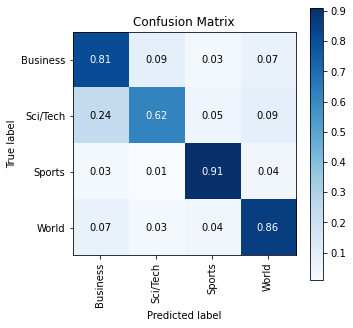

In [ ]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

In [ ]:
# Q8. Figure out what the values in the confusion matrix mean in relation to the model's performance
# A8. It tells us how accurately the model predict in each class. 
# For example, out of all data in Business class, the accuracy that the model predicts correctly was 80%.
# The model said 9% wrong predicting as Sci/Tech, 3% wrong predicting as Sports, and 8% wrong predicting as World.

In [ ]:
# Q9. Once you have understood the performance metrics of the model, try to tweak some hyper parameters to improve them further.
# State the changes that have improved the model's performance below (and provide code cells of the metrics and confusion matrix)
# I changed the learning rate as 0.01 and increased the number of epochs as 20, and the accuracy of some classes got slightly better.
# The Code is as follows.

In [ ]:
from torch.optim import Adam

epochs = 20
learning_rate = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

train(model, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:33<00:00,  3.47it/s]


Epoch	   : 1
Train Loss : 0.420
Valid Loss : 0.525
Valid Acc  : 0.813


100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Epoch	   : 2
Train Loss : 0.316
Valid Loss : 0.547
Valid Acc  : 0.806


100%|██████████| 118/118 [00:24<00:00,  4.91it/s]


Epoch	   : 3
Train Loss : 0.294
Valid Loss : 0.571
Valid Acc  : 0.805


100%|██████████| 118/118 [00:24<00:00,  4.72it/s]


Epoch	   : 4
Train Loss : 0.291
Valid Loss : 0.582
Valid Acc  : 0.803


100%|██████████| 118/118 [00:24<00:00,  4.92it/s]


Epoch	   : 5
Train Loss : 0.292
Valid Loss : 0.562
Valid Acc  : 0.806


100%|██████████| 118/118 [00:23<00:00,  4.93it/s]


Epoch	   : 6
Train Loss : 0.287
Valid Loss : 0.629
Valid Acc  : 0.785


100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Epoch	   : 7
Train Loss : 0.291
Valid Loss : 0.577
Valid Acc  : 0.808


100%|██████████| 118/118 [00:23<00:00,  5.00it/s]


Epoch	   : 8
Train Loss : 0.281
Valid Loss : 0.559
Valid Acc  : 0.816


100%|██████████| 118/118 [00:24<00:00,  4.91it/s]


Epoch	   : 9
Train Loss : 0.270
Valid Loss : 0.590
Valid Acc  : 0.805


100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Epoch	   : 10
Train Loss : 0.258
Valid Loss : 0.600
Valid Acc  : 0.810


100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


Epoch	   : 11
Train Loss : 0.249
Valid Loss : 0.618
Valid Acc  : 0.808


100%|██████████| 118/118 [00:24<00:00,  4.85it/s]


Epoch	   : 12
Train Loss : 0.249
Valid Loss : 0.605
Valid Acc  : 0.810


100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


Epoch	   : 13
Train Loss : 0.254
Valid Loss : 0.627
Valid Acc  : 0.805


100%|██████████| 118/118 [00:24<00:00,  4.86it/s]


Epoch	   : 14
Train Loss : 0.257
Valid Loss : 0.703
Valid Acc  : 0.782


100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Epoch	   : 15
Train Loss : 0.247
Valid Loss : 0.710
Valid Acc  : 0.786


100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


Epoch	   : 16
Train Loss : 0.231
Valid Loss : 0.669
Valid Acc  : 0.797


100%|██████████| 118/118 [00:23<00:00,  4.93it/s]


Epoch	   : 17
Train Loss : 0.221
Valid Loss : 0.679
Valid Acc  : 0.803


100%|██████████| 118/118 [00:23<00:00,  4.92it/s]


Epoch	   : 18
Train Loss : 0.216
Valid Loss : 0.673
Valid Acc  : 0.804


100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


Epoch	   : 19
Train Loss : 0.215
Valid Loss : 0.698
Valid Acc  : 0.799


100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


Epoch	   : 20
Train Loss : 0.214
Valid Loss : 0.728
Valid Acc  : 0.794


In [ ]:
Y_actual, Y_preds = MakePredictions(model, test_loader)

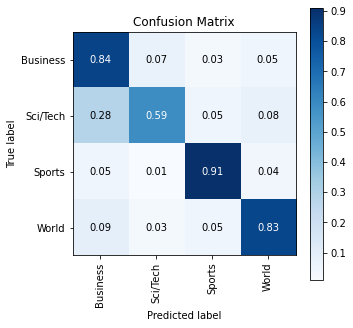

In [ ]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);